# Compare two MSAs

In [1]:
include("../functions_seq_based_metrics.jl")

count_mismatch (generic function with 1 method)

In [2]:
using DelimitedFiles, Plots

In [3]:
using Revise, Pkg
Pkg.activate("/home/louise/MSA/BpAlignGpu.jl")
using BpAlignGpu

  Activating project at `~/MSA/BpAlignGpu.jl`


In [4]:
using CUDA
CUDA.device!(1)

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA /home/louise/.julia/packages/CUDA/Uurn4/src/initialization.jl:70


CuDevice(1): TITAN RTX

In [5]:
T = Float32
q = 21
ctype=Symbol("amino")
typel=Symbol("bm")
muext = 0.00
muint = 2.50;

In [6]:
fam = "PF00397"

path = "/home/louise/MSA/Data/test/PF00397/"
open(path)
L = 31; 

param_file = path * "Parameters_plm_PF00397.dat"
J, H = BpAlignGpu.read_parameters(param_file, q, L, gap=0, typel=typel);

delta = 5;
file_full = path * "PF00397_full_length_sequences.fasta"
file_hmmer = path * "PF00397_full.fasta"
file_hmmer_ins = path * "PF00397_full.inse"
al = BpAlignGpu.enveloptoalign( file_full, file_hmmer, file_hmmer_ins, delta = delta, ctype = ctype);
M = length(al)

using DelimitedFiles
lambda_file = path * "Lambda_PF00397.dat"
Lambda_all = readdlm(lambda_file)
lambda_o = Lambda_all[1,:];
lambda_e = Lambda_all[2,:];

┌ Info: Assuming J i j a b and h i a format
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:37
┌ Info: Output tersors: J[a b i j] and h[a i]
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:39
┌ Info: Gap in input file 0 now in 21
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:40


In [6]:
fam = "PF00684"
open("/home/louise/MSA/Data/test/PF00684/")
L = 67; 

J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00684/Parameters_bm_PF00684seed_potts.dat", q, L, gap=0, typel=typel);

delta = 50;
al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00684/Test_PF00684.full", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.fasta", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.ins", delta = delta, ctype = ctype);
M = length(al)

Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00684/Lambda_PF00684.dat")
lambda_o = Lambda_all[:,1];
lambda_e = Lambda_all[:,2];


┌ Info: Assuming J i j a b and h i a format
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:37
┌ Info: Output tersors: J[a b i j] and h[a i]
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:39
┌ Info: Gap in input file 0 now in 21
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:40


In [7]:
function extract_data(namefile::String)
    data = readdlm(namefile);
    param = data[1,:] #param = data[1,1:np]
    nsamp =param[1]

    inds = data[2,1:nsamp];
    res = data[3:end,:];

    xnsols = fill((0,0), L, nsamp)
    for ns in 1:nsamp
        for i=1:L
            x = res[ns,i]
            n = res[ns,L+i]
            xnsols[i,ns] = (x,n)
        end
    end

    sats = []
    ens = []
    seqpas = []
    for (i, idx0) in pairs(inds)
    #    @show i, idx0
        seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
        N = length(al[idx0][2])
        pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)

        c = BpAlignGpu.check_sr!(xnsols[:,i], L, N)

        seqsol = BpAlignGpu.convert_soltosequence!(xnsols[:,i], seq.strseq, N, L)
        energy = BpAlignGpu.compute_potts_en(pm.J, pm.H, seqsol[1], pm.L, seq.ctype)
#        energy = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
        append!(sats, sum(c))
        append!(ens, energy)
        append!(seqpas, [seqsol[1]])
    end
    return param, inds, sats, ens, xnsols, seqpas
end


extract_data (generic function with 1 method)

### Loads MSAs

#### "run_GS" files

In [53]:
path = ""

nsamples = "100"
method = "mf"
decim = "nucleation"
namefile = path * "run_GS_"*fam*"_n"*nsamples*"_"*method*"_"*decim*".txt"
param1, inds1, sats1, ens1, xnsols1, seqpas1 = extract_data(namefile);

method = "mf"
decim = "viterbi"
namefile = path * "run_GS_"*fam*"_n"*nsamples*"_"*method*"_"*decim*".txt"
param2, inds2, sats2, ens2, xnsols2, seqpas2 = extract_data(namefile);

In [54]:
inds1 == inds2

true

In [35]:
nsamples = "14"

method = "sce"
decim = "nucleation"
namefile = path * "run_GS_"*fam*"_n"*nsamples*"_"*method*"_"*decim*"_damp0p5.txt"
param1_d, inds1_d, sats1_d, ens1_d, xnsols1_d, seqpas1_d = extract_data(namefile);

j=0
for i in inds1
    if i in inds1_d
        @show i
        j += 1
        sats1[i] = sats1_d[j]
        ens1[i] = ens1_d[j]
        xnsols1[:,i] = xnsols1_d[:,j]
        seqpas1[i] = seqpas1_d[j]
    end
end
nsamples = "5"

method = "sce"
decim = "nucleation"
namefile = path * "run_GS_"*fam*"_n"*nsamples*"_"*method*"_"*decim*"_damp0p9.txt"
param1_d9, inds1_d9, sats1_d9, ens1_d9, xnsols1_d9, seqpas1_d9 = extract_data(namefile);

j=0
for i in inds1
    if i in inds1_d9
        @show i
        j += 1
        sats1[i] = sats1_d9[j]
        ens1[i] = ens1_d9[j]
        xnsols1[:,i] = xnsols1_d9[:,j]
        seqpas1[i] = seqpas1_d9[j]
    end
end

i = 17
i = 21
i = 38
i = 48
i = 50
i = 56
i = 57
i = 60
i = 65
i = 69
i = 70
i = 76
i = 85
i = 96
i = 24
i = 48
i = 60
i = 65
i = 96


In [36]:
nsamples = "14"

method = "sce"
decim = "viterbi"
namefile = path * "run_GS_"*fam*"_n"*nsamples*"_"*method*"_"*decim*"_damp0p5.txt"
param2_d, inds2_d, sats2_d, ens2_d, xnsols2_d, seqpas2_d = extract_data(namefile);

j=0
for i in inds2
    if i in inds2_d
        @show i
        j += 1
        sats2[i] = sats2_d[j]
        ens2[i] = ens2_d[j]
        xnsols2[:,i] = xnsols2_d[:,j]
        seqpas2[i] = seqpas2_d[j]
    end
end

i = 17
i = 21
i = 38
i = 48
i = 50
i = 56
i = 57
i = 60
i = 65
i = 69
i = 70
i = 76
i = 85
i = 96


In [37]:
[inds2_d]

1-element Vector{Vector{Any}}:
 [17, 21, 38, 48, 50, 56, 57, 60, 65, 69, 70, 76, 85, 96]

In [38]:
nsamples = "5"

method = "sce"
decim = "viterbi"
namefile = path * "run_GS_"*fam*"_n"*nsamples*"_"*method*"_"*decim*"_damp0p9.txt"
param2_d9, inds2_d9, sats2_d9, ens2_d9, xnsols2_d9, seqpas2_d9 = extract_data(namefile);

j=0
for i in inds2
    if i in inds2_d9
        @show i
        j += 1
        sats2[i] = sats2_d9[j]
        ens2[i] = ens2_d9[j]
        xnsols2[:,i] = xnsols2_d9[:,j]
        seqpas2[i] = seqpas2_d9[j]
    end
end

i = 24
i = 48
i = 60
i = 65
i = 96


In [39]:
[inds2_d9]

1-element Vector{Vector{Any}}:
 [48, 60, 96, 24, 65]

In [40]:
seqpas2

100-element Vector{Any}:
 "CGVCKGSGARGAKAKQCAKCEGNGITVNSA--GGGVIGVSKAMCTDCSGEGEKLREKDRCKKCKGNK"
 "CPECHGSGAEKGFPVTCPTCQGKGRVARATQSFGTFM--TSSTCPTCKAEGSVI--EKKCSTCTGKG"
 "CERCDGKGNEPGTVQHCHYCSGSGM--ETINTFVM-----RSTCRRCGGRGSII--TNPCVVCRGAG"
 "CATCGGSGAKPGTPITCRKCGGRGTIQVERRTLGNMM--TEQECDVCHGSGKEI--EEKCETCHGSG"
 "CTVCHGSGSEAGGRKVCATCQGSGQVRRSS-GFSI-----ASPCPSCSGEGYMI--DKPCRACGGSG"
 "CAACKGSGVKPGTPVSCVTCGGLGVEQMGLGGFRM-----RTTCPACKGAGKIY--KEKCADCRGAG"
 "CQSCNGSGARKGSPKNCETCNGIGQVRIQQ-GFSI-----QQTCPHCHGEGKVI--TDPCTACHGQG"
 "CETCNGTGAKPGTPSSCGTCGGSGQVRRATRTFGSFT--QVSVCPTCNGSGQVI--EEKCGTCAGKG"
 "CDTCSGSGAKPGTPETCKHCQGTGQMNIEQNTFGRVV--NKRVCHHCSGTGKEI--KEKCTTCSGKG"
 "CSKCDGTGSQDKKTQTCHVCHGSGRVRIKRQ-LAPMIQQQDIPCQQCGGKGSVV--KHKCTTCQGN-"
 "CKTCEGSGAAPGTPETCDTCGGAGRVRAQQ-GFTM-----ERTCPRCNGKGKTI--KKPCKDCGGAG"
 "CDRCRGAGTAEGTVTTCDTCGGQGEIQSVQRSLGQVV--TARPCPVCRGFGEVI--TDPCQQCGGDG"
 "CEVCLGTGSKVGSMRICSTCGGRGQVMRTEQTFGLFS--QVSVCPNCGGDGEVI--SEYCRKCSGKG"
 ⋮
 "CQTCHGTGAKPGTPTTCTKCGGKGQIVYTSQSFGTVR--NVTTCPDC

#### "DCAlign" files

In [12]:
nsamples = "100"
namefile = path * "run_GS_"*fam*"_n"*nsamples*"_DCAlign.txt"
res_GS_DCA = readdlm(namefile);


In [13]:
nb_samps_DCA = size(res_GS_DCA,1)

100

In [14]:
inds_DCA = []
sats_DCA = []
ens_DCA = []
seqpas_DCA = []
for i in 1:nb_samps_DCA
    idx0 = res_GS_DCA[i,1]
    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
    N = length(al[idx0][2])
    pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)
    
    seqsol = (String(res_GS_DCA[i,2]), String(res_GS_DCA[i,3]), res_GS_DCA[i,4], res_GS_DCA[i,5])
    energy = BpAlignGpu.compute_potts_en(pm.J, pm.H, seqsol[1], pm.L, seq.ctype)
#    energy = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
    
    sat = res_GS_DCA[i,6]    
    append!(inds_DCA, idx0)
    append!(sats_DCA, sat)
    append!(ens_DCA, energy)
    append!(seqpas_DCA, [res_GS_DCA[i,2]])
end
inds_DCA == inds2

true

#### hmmer

In [15]:
inds = inds2

ens_hmmer = []
seqpas_hmmer = []
for (i, idx0) in pairs(inds)
    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
    N = length(al[idx0][2])
    pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)
    
#    seqsol = al[idx0][4]
#    energy = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol, pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
    seqsol = al[idx0][3]
    energy = BpAlignGpu.compute_potts_en(pm.J, pm.H, seqsol, pm.L, seq.ctype)
    append!(ens_hmmer, energy)
    append!(seqpas_hmmer, [al[idx0][3]])
end

In [16]:
seqpas_hmmer

100-element Vector{Any}:
 "CGVCKGSGARGAKAKQCAKCEGNGYITVNSARGGGVIGVSKAMCTDCSGEGEKLREKDRCKKCKGNK"
 "CPECHGSGAEKGFPVTCPTCQGKGRVARATQSFGTFM--TSSTCPTCKAEGSVI--EKKCSTCTGKG"
 "CERCDGKGNEPGTVQHCHYCSGSGMETIN---TGPFV--MRSTCRRCGGRGSII--TNPCVVCRGAG"
 "CATCGGSGAKPGTPITCRKCGGRGTIQVERRTLGNMM--TEQECDVCHGSGKEI--EEKCETCHGSG"
 "CTVCHGSGSEAGGRKVCATCQGSGQVRRSS---GFF--SIASPCPSCSGEGYMI--DKPCRACGGSG"
 "CAACKGSGVKPGTPVSCVTCGGLGAV--EQMGLGGMF-RMRTTCPACKGAGKIY--KEKCADCRGAG"
 "CQSCNGSGARKGSPKNCETCNGIGQVRIQQ---GFF--SIQQTCPHCHGEGKVI--TDPCTACHGQG"
 "CETCNGTGAKPGTPSSCGTCGGSGQVRRATRTFGSFT--QVSVCPTCNGSGQVI--EEKCGTCAGKG"
 "CDTCSGSGAKPGTPETCKHCQGTGQMNIEQNTFGRVV--NKRVCHHCSGTGKEI--KEKCTTCSGKG"
 "CSKCDGTGSQDKKTQTCHVCHGSGRVRIKRQ-LAPMIQQQDIPCQQCGGKGSVV--KHKCTTCQGN-"
 "CKTCEGSGAAPGTPETCDTCGGAGRVRAQQ---GFFT--MERTCPRCNGKGKTI--KKPCKDCGGAG"
 "CDRCRGAGTAEGTVTTCDTCGGQGEIQSVQRSLGQVV--TARPCPVCRGFGEVI--TDPCQQCGGDG"
 "CEVCLGTGSKVGSMRICSTCGGRGQVMRTEQTFGLFS--QVSVCPNCGGDGEVI--SEYCRKCSGKG"
 ⋮
 "CQTCHGTGAKPGTPTTCTKCGGKGQIVYTSQSFGTV--RNVTTCPDC

# scatter plot of energies

In [55]:
Es1 = ens_DCA
Es2 = ens2
findall(Es1 - Es2 .> 0)

8-element Vector{Int64}:
  6
 24
 38
 48
 57
 65
 96
 98

In [56]:
findall(Es1 - Es2 .< 0)

4-element Vector{Int64}:
  1
 31
 34
 80

In [57]:
diffE = Es1 .- Es2;
diffE[findall(Es1 - Es2 .< 0)]./L

4-element Vector{Float32}:
 -0.010653824
 -0.010934402
 -0.06380702
 -0.0642978

In [58]:
diffE[findall(Es1 - Es2 .> 0)]./L

8-element Vector{Float32}:
 0.14320624
 0.028928386
 0.05789435
 0.17238104
 0.053824127
 0.07562575
 0.06384118
 0.0014878458

In [59]:
length(inds2)

100

In [60]:
#notconverged = [24,60,70]
inds2 = vcat(1:23, 25:59, 61:69, 71:100);
#diffEcut = vcat(diffE[1:182], diffE[184:200]);

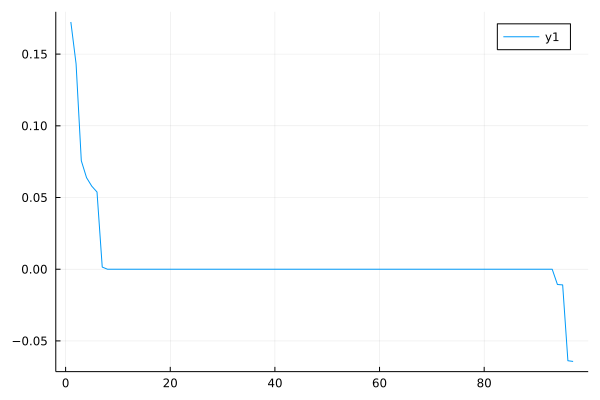

In [62]:
plot(sort(diffE[inds2]./L,rev=true))

In [51]:
diffE

100-element Vector{Float32}:
  4.383026
  0.0
  0.0
  0.0
  0.0
 12.292023
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
 37.512527
  0.0
  3.4672852
 16.55426
  0.0
  0.0
  4.0659027
 70.35253
  0.0
  0.819046
  0.0
 25.986923

In [52]:
namefile = "data_compareMSA.txt"
open(namefile, "a") do io
    writedlm(io, [diffE[:]])
end    


# Hamming distance

In [28]:
[inds2]

1-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  91, 92, 93, 94, 95, 96, 97, 98, 99, 100]

In [29]:
MSA1 = seqpas_hmmer[inds2]
MSA2 = seqpas2[inds2];


In [30]:
Hdist = []
for i in eachindex(inds2)
    dist = hamming_distance(MSA1[i], MSA2[i])
    #if dist > 0
    #    @show i, dist
    #end
    append!(Hdist, dist)
end

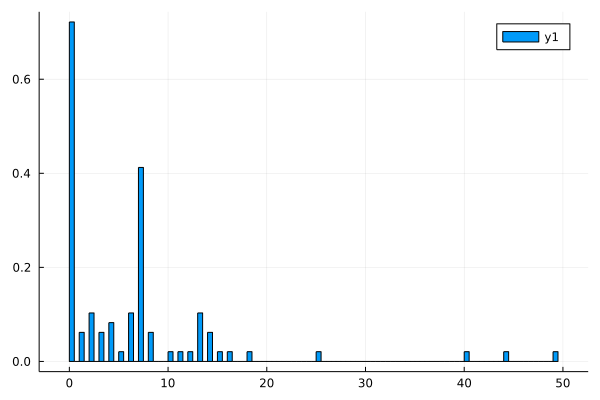

In [31]:
histogram(Hdist, bins = 100, normed = true)

In [32]:
open(namefile, "a") do io
    writedlm(io, [Hdist])
end    


# GAP +/-

In [33]:
Gp = []
Gm = []
for i in eachindex(inds2)
    np, nm = count_gap_pm(MSA1[i], MSA2[i])
    append!(Gp, np)
    append!(Gm, nm)
end

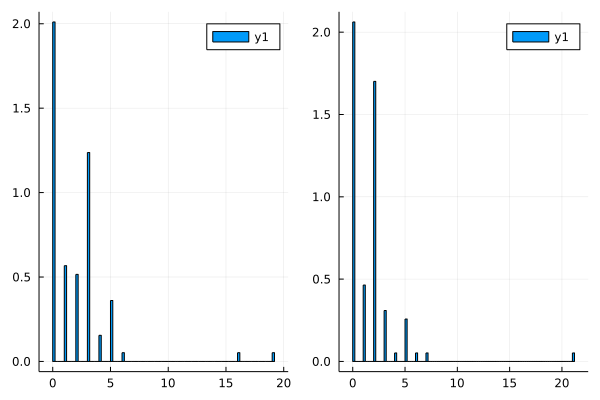

In [34]:
plot(histogram(Gp, bins = 100, normed = true), histogram(Gm, bins = 100, normed = true))

In [35]:
open(namefile, "a") do io
    writedlm(io, [Gp])
    writedlm(io, [Gm])
end    


# Mismatch

In [36]:
Mism = []
for i in eachindex(inds2)
    m = count_mismatch(MSA1[i], MSA2[i])
    append!(Mism, m)
end

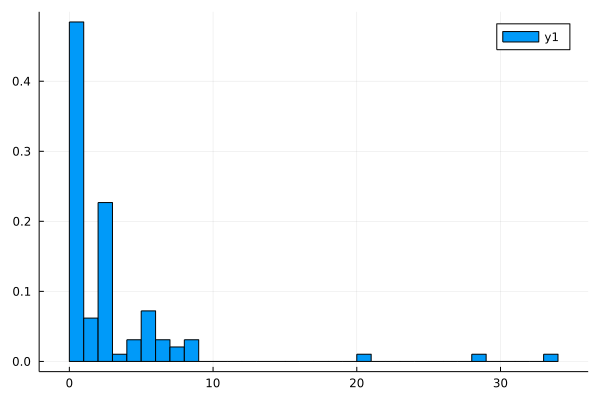

In [37]:
histogram(Mism, bins = 50, normed = true)

In [38]:
open(namefile, "a") do io
    writedlm(io, [Mism])
end    


# Proximity

In [54]:
MSA1 = seqpas_hmmer

100-element Vector{Any}:
 "CGVCKGSGARGAKAKQCAKCEGNGYITVNSARGGGVIGVSKAMCTDCSGEGEKLREKDRCKKCKGNK"
 "CPECHGSGAEKGFPVTCPTCQGKGRVARATQSFGTFM--TSSTCPTCKAEGSVI--EKKCSTCTGKG"
 "CERCDGKGNEPGTVQHCHYCSGSGMETIN---TGPFV--MRSTCRRCGGRGSII--TNPCVVCRGAG"
 "CATCGGSGAKPGTPITCRKCGGRGTIQVERRTLGNMM--TEQECDVCHGSGKEI--EEKCETCHGSG"
 "CTVCHGSGSEAGGRKVCATCQGSGQVRRSS---GFF--SIASPCPSCSGEGYMI--DKPCRACGGSG"
 "CAACKGSGVKPGTPVSCVTCGGLGAV--EQMGLGGMF-RMRTTCPACKGAGKIY--KEKCADCRGAG"
 "CQSCNGSGARKGSPKNCETCNGIGQVRIQQ---GFF--SIQQTCPHCHGEGKVI--TDPCTACHGQG"
 "CETCNGTGAKPGTPSSCGTCGGSGQVRRATRTFGSFT--QVSVCPTCNGSGQVI--EEKCGTCAGKG"
 "CDTCSGSGAKPGTPETCKHCQGTGQMNIEQNTFGRVV--NKRVCHHCSGTGKEI--KEKCTTCSGKG"
 "CSKCDGTGSQDKKTQTCHVCHGSGRVRIKRQ-LAPMIQQQDIPCQQCGGKGSVV--KHKCTTCQGN-"
 "CKTCEGSGAAPGTPETCDTCGGAGRVRAQQ---GFFT--MERTCPRCNGKGKTI--KKPCKDCGGAG"
 "CDRCRGAGTAEGTVTTCDTCGGQGEIQSVQRSLGQVV--TARPCPVCRGFGEVI--TDPCQQCGGDG"
 "CEVCLGTGSKVGSMRICSTCGGRGQVMRTEQTFGLFS--QVSVCPNCGGDGEVI--SEYCRKCSGKG"
 ⋮
 "CQTCHGTGAKPGTPTTCTKCGGKGQIVYTSQSFGTV--RNVTTCPDC